## Support Vector Classifier for emotion, based on 4 simple features

Binary classification for each emotion. Trained with k fold cross validation and a loop over multiple shufflings of the data. Accuracy around 60%. Random is 50%.


##### Observe: Very often it puts all data in one category as the average of the means is (too) low for a (natural) threshold of 0.5. Idea to take into account weighted averages based on the amount of reported emotions per participant per song and do other stuff for imbalanced data.

why is the sum over the confusion matrices not the same?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Data import

ZC = np.load('../preprocessing/zeroCrossings_frame100ms_hop50ms.npy')
SC = np.load('../preprocessing/spectralCentroid_frame100ms_hop50ms.npy')
SV = np.load('../preprocessing/spectralVariance_frame5000ms_hop2500ms.npy')
ST = np.load('../preprocessing/staticTempoLibrosa.npy')

labels = pd.read_csv('../preprocessing/labels.csv')

In [3]:
# Only keep the emotion labels 
# These correspond to the average number each specific emotion was reported

# For classifying we threshold these averages at 0.5. 
# Average > 0.5: this emotion corresponds to this song
# Average < 0.5: emotion does not belong to this song

labels = labels.drop(['genre',
             'var_amazement',
             'var_solemnity',
             'var_tenderness',
             'var_nostalgia',
             'var_calmness',
             'var_power',
             'var_joyful_activation',
             'var_tension',
             'var_sadness',
             'mood',
             'var_mood',
             'liked',
             'var_liked',
             'disliked',
             'var_disliked',
             'age',
             'var_age',
             'gender',
             'var_gender',
             'number_of_observations',
             'track id'             
            ], axis=1)

emotions = list(labels)

In [4]:
np.mean(labels)

amazement            0.134012
solemnity            0.195961
tenderness           0.176911
nostalgia            0.254279
calmness             0.299257
power                0.190244
joyful_activation    0.261896
tension              0.237685
sadness              0.185288
dtype: float64

------------------------------

In [5]:
# Take the median over all frames for each song to have comparable dimensions

ZC = np.nanmedian(ZC, axis=1)
SC = np.nanmedian(SC, axis=1)
SV = np.nanmedian(SV, axis=1)

In [6]:
# OR take the mean in a certain interval

# ZC = np.mean(ZC[:, 100:200], axis=1)
# SC = np.mean(SC[:, 100:200], axis=1)
# SV = np.mean(SV[:, 2:4], axis=1)

In [7]:
# Make dataframe

features_dict_medians = {'ZC': ZC,
                         'SC': SC,
                         'SV': SV,
                         'StaticTempo': ST}
features = pd.DataFrame(data=features_dict_medians)

In [8]:
# Shuffle

def shuffleData(features, labels):
    n_data = len(features)
    idx = np.random.permutation(n_data)
    features, labels = features.reindex(idx), labels.reindex(idx)
    return features, labels

In [9]:
# K fold Crossvalidation

def kFoldConfusionMatrix(k, features, labels):

    kfold_train_metrics = []
    kfold_test_metrics = []

    confusion_Matrix = np.zeros((2,2))

    # # Drop NaN values
    # NaNidx = np.where(features.isnull().any(axis=1).tolist())[0]
    # # NaNidx = np.isnan(features)[np.isnan(features) == 1].stack().index.tolist()

    # total_input = features.drop(NaNidx)
    # total_labels = labels.drop(NaNidx)

    total_input = features
    total_labels = labels

    cv = KFold(n_splits=k)

    for train_index, test_index in cv.split(total_input):

        train_df, train_labels = total_input.iloc[train_index], total_labels.iloc[train_index]
        test_df, test_labels = total_input.iloc[test_index], total_labels.iloc[test_index]

        # Standardizing data
        mean = train_df.mean()
        std = train_df.std()

        train_df = (train_df - mean) / std
        test_df = (test_df - mean) / std

        # Classifier
        clf = svm.SVC(kernel='linear')
        clf.fit(train_df, train_labels)

        kfold_train_metrics.append(clf.score(train_df, train_labels))
        kfold_test_metrics.append(clf.score(test_df, test_labels))

        confusion_Matrix += confusion_matrix(test_labels, clf.predict(test_df)) 
        
    return confusion_Matrix

In [10]:
# Doing the actual training of the support vector classifier over multple rounds of shuffeling

threshold = 0.5

N_emotions = 9
N_features = 4

confusion_Matrix = np.zeros((N_emotions, 2, 2))

N_shuffles = 5
k = 10
accuracies = np.zeros((N_emotions, N_shuffles))

for e_idx, emotion in enumerate(emotions):
    for Siter in range(N_shuffles):
        thresholdedLabel = labels[emotion]
        thresholdedLabel[thresholdedLabel >= threshold] = int(1)
        thresholdedLabel[thresholdedLabel <  threshold] = int(0)

        features, thresholdedLabel = shuffleData(features, thresholdedLabel)

        confusion_Matrix[e_idx, :, :] += kFoldConfusionMatrix(k, features, thresholdedLabel)

        accuracies[e_idx, Siter] = np.sum(np.eye(2)*confusion_Matrix[e_idx, :, :])/np.sum(confusion_Matrix[e_idx, :, :])

EMOTION amazement: 

Accuracy: 0.5441556974886103 +- 0.002241066312896199 

[[1985. 1440.]
 [1455. 1440.]]



EMOTION solemnity: 

Accuracy: 0.7917548076923078 +- 0.03572115384615384 

[[1905.  200.]
 [ 295.  200.]]



EMOTION tenderness: 

Accuracy: 0.8319885552235782 +- 0.05154367461154504 

[[1865.  160.]
 [ 295.  160.]]



EMOTION nostalgia: 

Accuracy: 0.885 +- 0.0 

[[1770.    0.]
 [ 230.    0.]]



EMOTION calmness: 

Accuracy: 0.7775 +- 0.0 

[[1555.    0.]
 [ 445.    0.]]



EMOTION power: 

Accuracy: 0.8897230576940978 +- 0.021598246957615027 

[[1830.   40.]
 [ 210.   40.]]



EMOTION joyful_activation: 

Accuracy: 0.7925 +- 0.0 

[[1585.    0.]
 [ 415.    0.]]



EMOTION tension: 

Accuracy: 0.8875 +- 0.0 

[[1775.    0.]
 [ 225.    0.]]



EMOTION sadness: 

Accuracy: 0.8464397993311037 +- 0.055882761497874016 

[[1895.  200.]
 [ 305.  200.]]





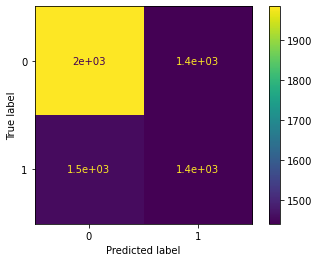

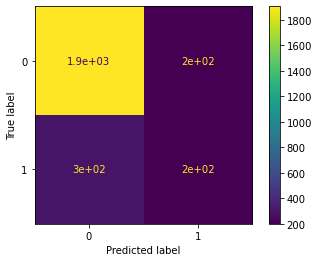

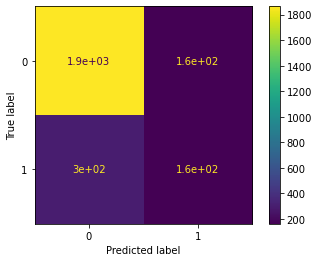

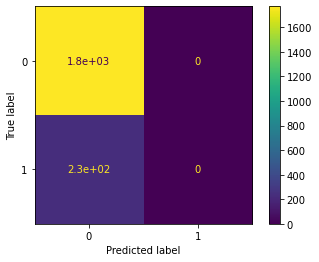

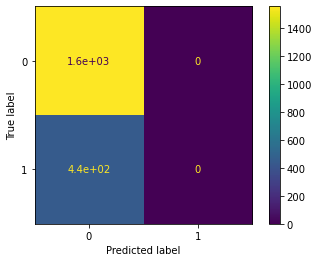

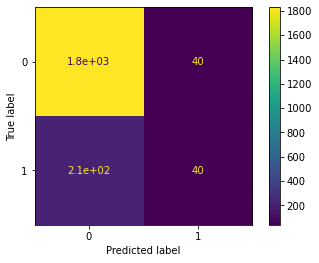

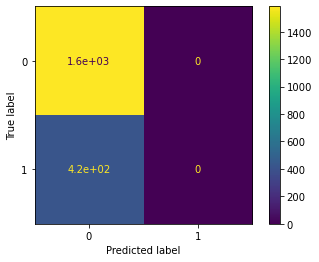

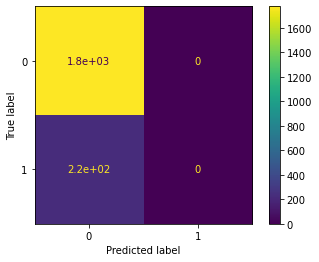

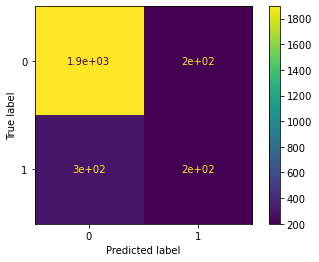

In [11]:
# Confusion matrix
for e_idx, emotion in enumerate(emotions):
    print(f'EMOTION {emotion}: \n')
    print(f'Accuracy: {np.mean(accuracies[e_idx, :])} +- {np.std(accuracies[e_idx, :])} \n')
    
    CMATRIX = confusion_Matrix[e_idx, :, :]
    print(CMATRIX)
    print('\n\n')
    CM = ConfusionMatrixDisplay(CMATRIX)
    CM.plot()